In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import numpy as np
from scipy import signal
import pandas as pd
import peakutils
from peakutils.plot import plot as pplot
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
#Read CSV file and have a look at the acceleration data
df = pd.read_csv("data/Xu/ACC.csv", delimiter=",")

In [4]:
#Define a class to process and visualize every moving behavior
class Processing:
    
    #initialize one moving behavior: remove mean, set length, time period, x,y,z, and magnitude
    def __init__(self, data):
        #self.data = self
        self.data = data
        #remove mean
        m = (np.sqrt((data ** 2).sum(axis = 1))).values
        m_mean = m.mean()
        self.m = m - m_mean
        self.length = data.shape[0]
        self.time = self.length / 32.
        self.t = np.linspace(0, self.time, self.length) #define time scale
#         print "Total Samples: ", self.length
        
    #a function to visualize acceleration data from one direction, peaks are optional
    def Plot_data(self, direction, dir_str, title, with_peaks = False, peaks = []):

        #define style for plot
        title_font = {'fontname':'Arial', 'size':'20'}
        axis_font = {'fontname':'Arial', 'size':'15'}

        fig, ax = plt.subplots(1,1,figsize = (20,5))
        #if true show peaks in the plot
        if (with_peaks):
            pplot(self.t, direction, peaks)
            ax.set_title('Peaks')
            ax.set_xlabel("time/s", **axis_font)
            ax.set_ylabel("ACC " + dir_str, **axis_font)
        
        #otherwise, just show acceleration data
        else:
            #plot
            ax.plot(self.t,direction)
            ax.set_xticks(np.arange(min(self.t), max(self.t), 10.0))
            ax.set_xlabel("time/s", **axis_font)
            ax.set_ylabel("ACC " + dir_str, **axis_font)
            ax.set_title(title, **title_font)
            
        return ax
        
    #a function to find peaks 
    def Peaks(self, direction, dir_str, thres, min_dist, plot = True):
        
        #define style for plot
        title_font = {'fontname':'Arial', 'size':'20'}
        axis_font = {'fontname':'Arial', 'size':'15'}
        
        indexes = peakutils.indexes(-direction, thres=thres, min_dist=min_dist)
        if plot:
            plt.figure(figsize=(20,5))
            pplot(self.t, direction, indexes[1:-1]) #skip the first and the last peaks
            plt.title('Walking Signal Peaks')
            plt.xlabel("time/s", **axis_font)
            plt.ylabel("ACC " + dir_str, **axis_font)

        return indexes[1:-1] 
        
    #Segment data by time
    def Clip(self, interval):

        start_time = interval[0]
        end_time = interval[1]
        start_sample = int(start_time/float(self.time) * self.length)
        end_sample = int(end_time/float(self.time) * self.length)
        
        return self.data.iloc[start_sample:end_sample,:]
    
    #plot segmented (repetitive) data and average feature
    def Segment_Feature(self, direction, buffer_size, peaks):
        
        #line up repetitive segments
        window_size = 2*buffer_size+1
        steps = np.zeros((len(peaks),window_size))
        for i,index in enumerate(peaks):
            temp = np.arange(index-buffer_size,index+buffer_size+1)
            steps[i,:] = direction[temp]

        steps = np.transpose(steps)

        
        fig, ax = plt.subplots(1,2,figsize=(20,5))
        
        #plot the repetitive segments
        t = np.linspace(0,window_size/32.0,window_size)
        mean_step = np.mean(steps,axis = 1)
        ax[0].plot(t.reshape(-1,1),steps,color = sns.color_palette()[0])
        ax[0].plot(t.reshape(-1,1),mean_step,color = 'r',linewidth = 4, label = "Mean Segment")
        ax[0].set_title("Plot of All Segments")
        ax[0].set_ylabel("Magnitude")
        ax[0].set_xlim(t[0],t[-1])
        ax[0].set_xlabel('time/s')
        ax[0].legend()     

Sampling Frequency: 32Hz
Length of the entire signal:  228.59375 s


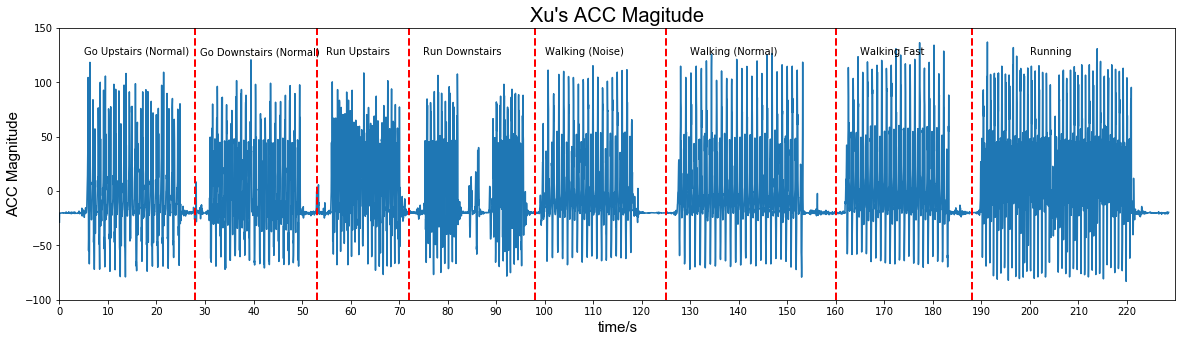

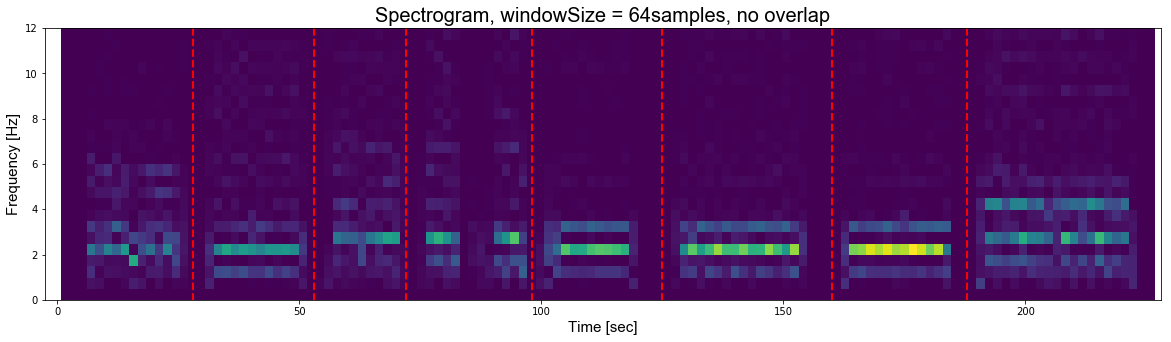

In [5]:
#--------------------------
#Plot the ACC magnitude data by time
#--------------------------

#read in the whole data
xu = Processing(df)
ax = xu.Plot_data(xu.m,"Magnitude", "Xu's ACC Magitude")
ax.plot([28, 28], [-100, 150], 'r--',lw=2)
ax.text(5, 125, 'Go Upstairs (Normal)')

ax.plot([53, 53], [-100, 150], 'r--',lw=2)
ax.text(29, 125, 'Go Downstairs (Normal)')

ax.plot([72, 72], [-100, 150], 'r--',lw=2)
ax.text(55, 125, 'Run Upstairs')

ax.plot([98, 98], [-100, 150], 'r--',lw=2)
ax.text(75, 125, 'Run Downstairs')

ax.plot([125, 125], [-100, 150], 'r--',lw=2)
ax.text(100, 125, 'Walking (Noise)')

ax.plot([160, 160], [-100, 150], 'r--',lw=2)
ax.text(130, 125, 'Walking (Normal)')

ax.plot([188, 188], [-100, 150], 'r--',lw=2)
ax.text(165, 125, 'Walking Fast')
ax.text(200, 125, 'Running')
ax.set_ylim(-100,150)
ax.set_xlim(0,230)


title_font = {'fontname':'Arial', 'size':'20'}
axis_font = {'fontname':'Arial', 'size':'15'}
    
plt.figure(figsize=(20,5))
f, t, Sxx = signal.spectrogram(xu.m, fs = 32, window=signal.get_window('boxcar', 64))
plt.pcolormesh(t, f, Sxx)
plt.ylim(0,12)
plt.xlim(-2.5,228)
plt.ylabel('Frequency [Hz]', **axis_font)
plt.xlabel('Time [sec]', **axis_font)
plt.title("Spectrogram, windowSize = 64samples, no overlap", **title_font)
plt.plot([28, 28], [-100, 150], 'r--',lw=2)
plt.plot([53, 53], [-100, 150], 'r--',lw=2)
plt.plot([72, 72], [-100, 150], 'r--',lw=2)
plt.plot([98, 98], [-100, 150], 'r--',lw=2)
plt.plot([125, 125], [-100, 150], 'r--',lw=2)
plt.plot([160, 160], [-100, 150], 'r--',lw=2)
plt.plot([188, 188], [-100, 150], 'r--',lw=2)

print ("Sampling Frequency: 32Hz")
print ("Length of the entire signal: ", len(xu.m)/32, 's')

**The average gait period is around 1s so we expect to see that the dominant frequency is around 1 Hz in the spectrogram. But since there are two salient summits within one period, namely 1s, the dominant frequency is thus around 2Hz**

**Take walking signal as an example**

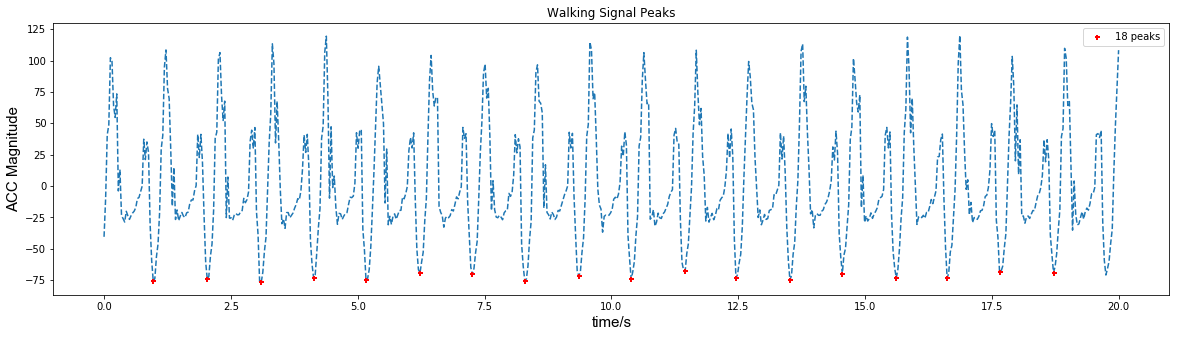

In [6]:
walking_normal = Processing(xu.Clip([130, 150]))
peaks = walking_normal.Peaks(walking_normal.m,"Magnitude", 0.3, 20 )